In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Implementation of Exercise 5.2 (a)

def single_mode_matricization(T, j):
    """
    Matricization of numpy array `T` by partitioning into j-th dimension and the remaining dimensions.
    """
    assert j < T.ndim
    # bring j-th dimension to the front
    T = np.transpose(T, [j] + list(range(j)) + list(range(j + 1, T.ndim)))
    T = np.reshape(T, (T.shape[0], -1)) # size of second dimension is inferred
    return T

In [3]:
# Implementation of Exercise 5.2 (b)

def single_mode_product(A, T, j):
    """
    Compute the j-mode product between the matrix `A` and tensor `T`.
    """
    T = np.tensordot(A, T, axes=(1, j))
    # original j-th dimension is now 0-th dimension; move back to j-th place
    T = np.transpose(T, list(range(1, j + 1)) + [0] + list(range(j + 1, T.ndim)))
    return T

In [4]:
class TuckerTensor(object):
    """
    Tucker format tensor.
    """
    def __init__(self, Ulist, C):
        self.Ulist = [np.array(U) for U in Ulist]
        # core tensor
        self.C = np.array(C)
        # dimension consistency checks
        assert len(self.Ulist) == self.C.ndim
        for j in range(self.C.ndim):
            assert self.Ulist[j].shape[1] == C.shape[j]

    @property
    def shape(self):
        """Logical dimensions."""
        return tuple([U.shape[0] for U in self.Ulist])

    @property
    def ndim(self):
        """Number of logical dimensions."""
        return len(self.Ulist)

    def as_full_tensor(self):
        """
        Construct the Tucker format tensor as full (dense) array.

        Note: Should only be used for debugging and testing.
        """
        T = self.C
        for j in range(T.ndim):
            # apply Uj to j-th dimension
            T = single_mode_product(self.Ulist[j], T, j)
        return T

In [5]:
# Implementation of Exercise 5.2 (d)

def higher_order_svd(T, max_ranks):
    """
    Compute the higher-order singular value decomposition
    (Tucker format approximation) of the NumPy array `T`.
    """
    assert T.ndim == len(max_ranks)
    Ulist = []
    σlist = []
    for j in range(T.ndim):
        A = single_mode_matricization(T, j)
        U, σ, Vh = np.linalg.svd(A, full_matrices=False)
        χ = U.shape[1]
        if max_ranks[j] > 0:
            # truncate in case max_ranks[j] < χ
            χ = min(χ, max_ranks[j])
        Ulist.append(U[:, :χ])
        σlist.append(σ)
    # form the core tensor
    C = T
    for j in range(C.ndim):
        # apply Uj^\dagger to j-th dimension
        C = single_mode_product(Ulist[j].conj().T, C, j)
    return TuckerTensor(Ulist, C), σlist

In [6]:
def fd_second_derivative_zero_boundary(n):
    """
    Finite difference discretization of -d^2/dx^2 on [0, 1] with zero boundary conditions.
    """
    return n**2 * (2*np.identity(n - 1) - np.diag(np.ones(n - 2), 1) - np.diag(np.ones(n - 2), -1))

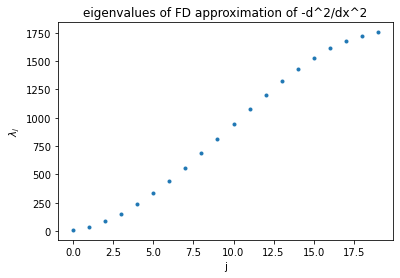

In [7]:
n = 21

A = fd_second_derivative_zero_boundary(n)

# visualize eigenvalues
plt.plot(np.linalg.eigvalsh(A), '.')
plt.xlabel("j")
plt.ylabel(r"$\lambda_j$")
plt.title("eigenvalues of FD approximation of -d^2/dx^2");

In [8]:
# A is symmetric and all eigenvalues are larger than zero, i.e., A is positive definite
min(np.linalg.eigvalsh(A))

9.851211269436485

In [9]:
# `L` operator as full matrix, as reference and for tests
L = (
    np.kron(np.kron(A,                   np.identity(len(A))), np.identity(len(A))) +
    np.kron(np.kron(np.identity(len(A)), A                  ), np.identity(len(A))) +
    np.kron(np.kron(np.identity(len(A)), np.identity(len(A))), A                  ))
print(L.shape)

(8000, 8000)


In [10]:
def quadratic_form_tucker_isometry(A, phi: TuckerTensor, j):
    """
    Construct the square matrix `K` which expresses <phi, L phi> with
    L = A x I x ... x I + ... + I x ... x I x A
    in dependence of the j-th isometry `phi.Ulist[j]`, such that
    <phi, L phi> = <u_j, K u_j> with u_j = phi.Ulist[j].flatten().
    """
    # all but j-th dimension
    jcompl = list(range(j)) + list(range(j + 1, phi.ndim))
    K = np.kron(A, np.tensordot(phi.C, phi.C, axes=(jcompl, jcompl)))
    for k in jcompl:
        M = phi.Ulist[k].T @ A @ phi.Ulist[k]
        K2 = np.tensordot(phi.C, single_mode_product(M, phi.C, k), axes=(jcompl, jcompl))
        K += np.kron(np.identity(len(A)), K2)
    return K

In [11]:
# test of `quadratic_form_tucker_isometry`
kdim_test = (2, 3, 4)
ϕtest = TuckerTensor([np.linalg.qr(np.random.randn(n-1, kdim_test[j]))[0] for j in range(3)], np.random.standard_normal(kdim_test))
ϕtvec = np.reshape(ϕtest.as_full_tensor(), -1)
utest = [np.reshape(ϕtest.Ulist[j], -1) for j in range(3)]
# reference value
ϕLϕref = np.dot(ϕtvec, L @ ϕtvec)
# relative error should be zero up to numerical rounding errors
err = [abs(np.dot(utest[j], quadratic_form_tucker_isometry(A, ϕtest, j) @ utest[j]) - ϕLϕref) / abs(ϕLϕref) for j in range(3)]
err

[1.223763470033382e-16, 1.223763470033382e-16, 3.6712904101001455e-16]

In [12]:
def linear_form_tucker_isometry(phi: TuckerTensor, b: TuckerTensor, j):
    """
    Construct the vector `g` which expresses <phi, b>
    in dependence of the j-th isometry `phi.Ulist[j]`, such that
    <phi, b> = <u_j, g> with u_j = phi.Ulist[j].flatten().
    """
    # all but j-th dimension
    jcompl = list(range(j)) + list(range(j + 1, phi.ndim))
    g = phi.C
    for k in jcompl:
        g = single_mode_product(b.Ulist[k].T @ phi.Ulist[k], g, k)
    g = b.Ulist[j] @ np.tensordot(b.C, g, axes=(jcompl, jcompl))
    assert g.shape == phi.Ulist[j].shape
    return np.reshape(g, -1)

In [13]:
def quadratic_form_tucker_core(A, phi: TuckerTensor):
    """
    Construct the square matrix `K` which expresses <phi, L phi> with
    L = A x I x ... x I + ... + I x ... x I x A
    in dependence of the core tensor `phi.C`, such that
    <phi, L phi> = <c, K c> with c = phi.C.flatten().
    """
    K = np.zeros((phi.C.size, phi.C.size))
    for j in range(phi.ndim):
        K1 = np.identity(1)
        for k in range(phi.ndim):
            K1 = np.kron(K1, phi.Ulist[k].T @ A @ phi.Ulist[k] if k == j else np.identity(phi.Ulist[k].shape[1]))
        K += K1
    return K

In [14]:
def linear_form_tucker_core(phi: TuckerTensor, b: TuckerTensor):
    """
    Construct the vector `g` which expresses <phi, b>
    in dependence of the core tensor `phi.C`, such that
    <phi, b> = <c, g> with c = phi.C.flatten().
    """
    # construct temporary Tucker format tensor
    Alist = [phi.Ulist[j].T @ b.Ulist[j] for j in range(phi.ndim)]
    g = TuckerTensor(Alist, b.C).as_full_tensor()
    return np.reshape(g, -1)

In [15]:
def factorized_tucker_als_step(A, phi: TuckerTensor, b: TuckerTensor):
    """
    Alternating Least Squares (ALS) optimization step of a Tucker format tensor `phi`
    for target function 1/2 <phi, L phi> - <phi, b> with
    L = A x I x ... x I + ... I x ... x I x A.
    """
    assert phi.ndim == b.ndim
    # optimize U matrices one-by-one
    for j in range(phi.ndim):
        # construct least squares terms for Ulist[j]
        K = quadratic_form_tucker_isometry(A, phi, j)
        g = linear_form_tucker_isometry(phi, b, j)
        Ujnext = np.reshape(np.linalg.solve(K, g), phi.Ulist[j].shape)
        # perform QR decomposition to ensure Ulist[j] remains an isometry
        phi.Ulist[j], R = np.linalg.qr(Ujnext, mode='reduced')
        # absorb R into core tensor
        phi.C = single_mode_product(R, phi.C, j)
    # optimize core tensor
    K = quadratic_form_tucker_core(A, phi)
    g = linear_form_tucker_core(phi, b)
    phi.C = np.reshape(np.linalg.solve(K, g), phi.C.shape)
    # result is stored in updated `phi`

In [16]:
# construct `b` tensor

bfull = np.array([[[np.sin(3*np.pi*(i + j + k)/n) for k in range(1, n)] for j in range(1, n)] for i in range(1, n)])
print("bfull.shape:", bfull.shape)

# keep only 2 singular values along each dimension
b, σlistb = higher_order_svd(bfull, [2, 2, 2])

print("b Tucker approximation error:", np.linalg.norm(np.reshape(b.as_full_tensor() - bfull, -1)) / np.linalg.norm(np.reshape(bfull, -1)))

bfull.shape: (20, 20, 20)
b Tucker approximation error: 1.7274174823583218e-15


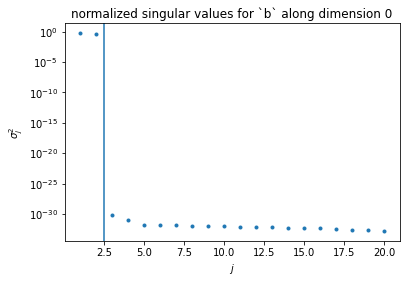

In [17]:
# show some singular values from HOSVD of `b`
plt.semilogy(range(1, len(σlistb[0]) + 1), σlistb[0]**2 / np.sum(σlistb[0]**2), '.')
plt.axvline(x=2.5)
plt.ylabel("$\\sigma_j^2$")
plt.xlabel("$j$")
plt.title("normalized singular values for `b` along dimension 0");
plt.show()

Solving reference linear system...
done.
ϕref.shape: (20, 20, 20)


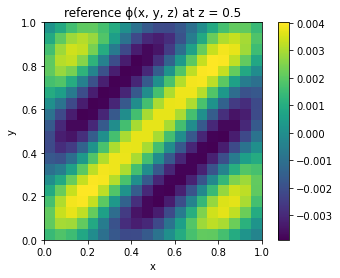

In [18]:
# reference solution
print("Solving reference linear system...")
ϕref = np.reshape(np.linalg.solve(L, np.reshape(bfull, -1)), bfull.shape)
print("done.")
print("ϕref.shape:", ϕref.shape)
plt.imshow(ϕref[:, :, n//2], extent=[0,1,0,1])
plt.xlabel("x")
plt.ylabel("y")
plt.title("reference ϕ(x, y, z) at z = 0.5")
plt.colorbar()
plt.show()

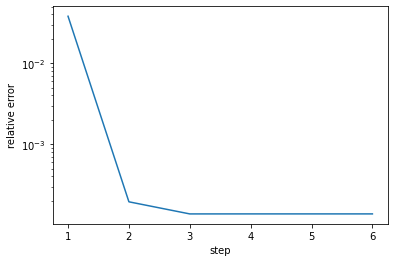

In [19]:
# run optimization

# initial tensor
np.random.seed(42)
k = 4
ϕ = TuckerTensor([np.linalg.qr(np.random.randn(n-1, k), mode='reduced')[0] for _ in range(3)], np.random.randn(k, k, k))

numiter = 6
errlist = []
for i in range(numiter):
    factorized_tucker_als_step(A, ϕ, b)
    errlist.append(np.linalg.norm(ϕ.as_full_tensor() - ϕref) / np.linalg.norm(ϕref))

plt.semilogy(range(1, numiter + 1), errlist)
plt.xlabel("step")
plt.ylabel("relative error")
plt.show()

In [20]:
# core tensor
ϕ.C.shape

(4, 4, 4)

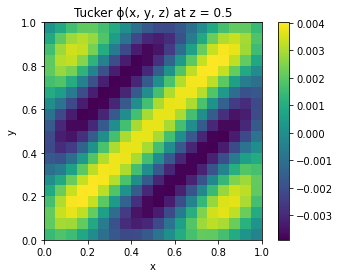

In [21]:
# visualize Tucker format approximation (should be visually indistinguishable from reference solution)
ϕfull = ϕ.as_full_tensor()
plt.imshow(ϕfull[:, :, n//2], extent=[0,1,0,1])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Tucker ϕ(x, y, z) at z = 0.5")
plt.colorbar()
plt.show()